In [21]:
import torch
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from shapely import wkt
from tqdm import tqdm
from geopy.distance import great_circle
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

from tensorboardX import SummaryWriter
from datetime import datetime

tqdm.pandas()

In [2]:
class MigrationDataset(InMemoryDataset):
    def __init__(self, root, transform=None):
        super(MigrationDataset, self).__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = []
        for file in os.listdir(self.root):
            if file.endswith(".geojson") or file.endswith(".csv"):
                files.append(file)
        return files
        
    @property
    def processed_file_names(self):
        return ['migration_dataset']

    def download(self):
        pass
    
    def process(self):
        
        # read files in specified folder
        cities = gpd.read_file(os.path.join(self.root, "cities_aggregated.geojson")).set_index("city")
        responses = gpd.read_file(os.path.join(self.root, "responses_clustered.csv"))


        # extract cities features 
        cities_features = cities[[
            "population",
            "city_category", 
            "harsh_climate", 
            "ueqi_score", 
            "ueqi_residential", 
            "ueqi_street_networks", 
            "ueqi_green_spaces", 
            "ueqi_public_and_business_infrastructure", 
            "ueqi_social_and_leisure_infrastructure",
            "ueqi_citywide_space",
            "cvs_total",
            "vacancies_total",
            "factories_count"
            ]]

        # encode categorical features
        one_hot = OneHotEncoder()
        encoded_category = one_hot.fit_transform(np.expand_dims(cities["city_category"].to_numpy(), 1)).toarray()
        encoded_category_names = one_hot.get_feature_names_out(["category"])
        cities_features.loc[:, encoded_category_names] = encoded_category
        cities_features = cities_features.drop(["city_category"], axis=1)
        cities_features["harsh_climate"] = cities_features["harsh_climate"].astype(int)

        # form distance matrix
        DM = cities["geometry"].progress_apply(
            lambda p1: cities["geometry"].apply(
                lambda p2: great_circle(p1.coords[0], p2.coords[0]).km
                ))

        # form origin-destination matrix

        responses_counts = responses.groupby(["cluster_center_cv", "cluster_center_vacancy"])["id_candidate"].count()
        responses_cities = responses_counts.index.get_level_values(0).drop_duplicates()
        OD = pd.DataFrame(None, index=DM.columns, columns=DM.columns)
        OD = OD.progress_apply(
            lambda city: city.fillna(responses_counts[city.name]).fillna(0) 
            if city.name in responses_cities else city.fillna(0)
            )
        
        # transform data
        
        cities_num = len(OD)
        edge_index = [[], []]
        for i in range(cities_num):
            edge_index[0].extend([i for j in range(cities_num)])
            edge_index[1].extend([j for j in range(cities_num)])

        edge_index = torch.tensor(edge_index)
        y = torch.tensor(np.concatenate((OD.to_numpy())), dtype=torch.float32)
        edge_attr = torch.tensor(np.concatenate((DM.to_numpy())), dtype=torch.float32)
        x = torch.tensor(cities_features.to_numpy(), dtype=torch.float32)

        # exclude diagonal
        non_diagonal = edge_attr > 0
        edge_attr = edge_attr[non_diagonal]
        edge_index = edge_index[:, non_diagonal]
        y = y[non_diagonal]
        
        # create torch object          
        graph = Data(x=x,edge_index=edge_index, y=y, edge_attr=edge_attr)
        
        data_list = []
        data_list.append(graph)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [3]:
dataset = MigrationDataset("/var/essdata/IDU/other/mm_22/industrial-location/ml/data")

In [4]:
# split to the train and test set
data = dataset.data
perm = torch.randperm(data.num_edges)
data.train_idx = perm[:int(0.7 * data.num_edges)]
data.test_idx = perm[int(0.7 * data.num_edges):]

/var/essdata/IDU/venvs/ml_venv/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [5]:
def split_train_test(x, edge_index, edge_weight, mask):

    x, edge_index, edge_weight = dataset.x, dataset.edge_index[:, mask], dataset.edge_attr[mask].unsqueeze(-1)
    y = dataset.y[mask]

    x_s = x[edge_index[0]]
    x_d = x[edge_index[1]]
    x = torch.cat((x_s, x_d, edge_weight), axis=1)

    return x, y

In [7]:
data = torch.load("data/train_test_split/data.pt")

In [8]:
X_train, Y_train = split_train_test(data.x, data.edge_index, data.edge_weight, data.train_idx)
X_test, Y_test = split_train_test(data.x, data.edge_index, data.edge_weight, data.test_idx)
train_data = Pool(data=X_train.numpy(), label=Y_train.numpy())
test_data = Pool(data=X_test.numpy(), label=Y_test.numpy())

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train.numpy(), Y_train.numpy())

test_predictions =  lr_model.predict(X_test)
train_predictions =  lr_model.predict(X_train)

print("Test RMSE:", np.sqrt(mean_squared_error(Y_test, test_predictions)), "\n"
      "Test R2:", r2_score(Y_test, test_predictions), "\n\n"
      "Train RMSE:", np.sqrt(mean_squared_error(Y_train, train_predictions)), "\n"
      "Test R2:", r2_score(Y_train, train_predictions))

Test RMSE: 17.455324 
Test R2: 0.08144620860649476 

Train RMSE: 19.951221 
Test R2: 0.05343581722099955


In [ ]:
rfr_model = RandomForestRegressor(n_estimators=300)
rfr_model.fit(X_train, Y_train)

test_predictions =  rfr_model.predict(X_test)
train_predictions =  rfr_model.predict(X_train)

print("Test RMSE:", np.sqrt(mean_squared_error(Y_test, test_predictions)), "\n"
      "Test R2:", r2_score(Y_test, test_predictions), "\n\n"
      "Train RMSE:", np.sqrt(mean_squared_error(Y_train, train_predictions)), "\n"
      "Train R2:", r2_score(Y_train, train_predictions))

In [10]:
%matplotlib inline
model = CatBoostRegressor(iterations=100, learning_rate=1, depth=6, loss_function='RMSE', eval_metric="R2", verbose=10)
fit_model = model.fit(train_data, eval_set=[train_data, test_data], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5372289	test: 0.5372289	test1: 0.5381497	best: 0.5381497 (0)	total: 141ms	remaining: 14s
10:	learn: 0.8942964	test: 0.8942964	test1: 0.7030923	best: 0.7063423 (5)	total: 476ms	remaining: 3.85s
20:	learn: 0.9233960	test: 0.9233960	test1: 0.7168478	best: 0.7168478 (20)	total: 756ms	remaining: 2.84s
30:	learn: 0.9420826	test: 0.9420826	test1: 0.7184769	best: 0.7194153 (24)	total: 1.07s	remaining: 2.38s
40:	learn: 0.9521414	test: 0.9521414	test1: 0.7137505	best: 0.7194153 (24)	total: 1.36s	remaining: 1.95s
50:	learn: 0.9573126	test: 0.9573126	test1: 0.7192343	best: 0.7194153 (24)	total: 1.72s	remaining: 1.66s
60:	learn: 0.9616175	test: 0.9616175	test1: 0.7160084	best: 0.7221056 (51)	total: 2.06s	remaining: 1.32s
70:	learn: 0.9646623	test: 0.9646623	test1: 0.7150441	best: 0.7221056 (51)	total: 2.3s	remaining: 938ms
80:	learn: 0.9676899	test: 0.9676899	test1: 0.7159729	best: 0.7221056 (51)	total: 2.56s	remaining: 601ms
90:	learn: 0.9699531	test: 0.9699531	test1: 0.7176921	best: 0

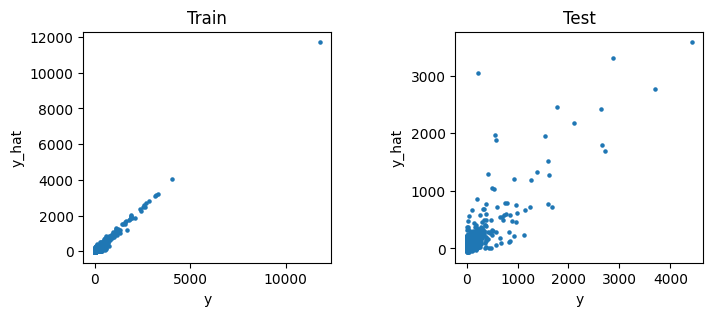

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plt.subplots_adjust(wspace=0.5)

y_hat_train = fit_model.predict(train_data)
y_train = data.y[data.train_idx].numpy()

y_hat_test = fit_model.predict(test_data)
y_test = data.y[data.test_idx].numpy()

ax1.scatter(y_train,y_hat_train, s=5)
ax1.set_xlabel("y")
ax1.set_ylabel("y_hat")
ax1.set_title("Train")

ax2.scatter(y_test,y_hat_test, s=5)
ax2.set_xlabel("y")
ax2.set_ylabel("y_hat")
ax2.set_title("Test")

plt.show()

In [112]:
print("R2 score for negative edges:", r2_score(y_test[y_test == 0], y_hat_test[y_test == 0].round()))
print("R2 score for positive edges:", r2_score(y_test[y_test > 0], y_hat_test[y_test > 0].round()).round(3))

R2 score for negative edges: 0.0
R2 score for positive edges: 0.722


In [11]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(FNN, self).__init__()

        self.num_layers = num_layers

        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(self.num_layers - 2):
            self.lins.append(nn.Linear(hidden_dim, hidden_dim))
        self.lins.append(nn.Linear(hidden_dim, 1))

        self.norm = nn.ModuleList()
        for l in range(self.num_layers):
            self.norm.append(nn.LayerNorm(hidden_dim))

        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr):

        edge_weight = edge_attr.unsqueeze(-1)

        x_s = x[edge_index[0]]
        x_d = x[edge_index[1]]
        y = torch.cat((x_s, x_d, edge_weight), axis=1)
        y = F.normalize(y)

        for i in range(self.num_layers - 1):
            y = self.lins[i](y) 
            y = nn.functional.leaky_relu(y)
            y = F.dropout(y, p=self.dropout, training=self.training)
            y = self.norm[i](y)

        y = self.lins[-1](y)
        y = torch.relu(y).squeeze()
        
        return y

In [12]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def train_func(data, model, epochs, writer):

    optimize = torch.optim.Adam(list(model.parameters()),  lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimize, factor=0.9, min_lr=0.0001)

    # train
    for epoch in range(epochs + 1):

        optimize.zero_grad()
        model.train()
        y_train = data.y[data.train_idx]
        y_hat = model(data.x, data.edge_index[:, data.train_idx], data.edge_attr[data.train_idx])

        loss = F.mse_loss(y_hat, y_train)
        r2 = r2_loss(y_hat, y_train)

        loss.backward()
        optimize.step()

        t_metrics = {"train_loss": loss, "train_r2": r2}  
        for name, t_metric in t_metrics.items(): writer.add_scalar(name, t_metric, epoch)

        if epoch % 10 == 0: 

            v_metrics = val_func(data, model)
            scheduler.step(v_metrics["test_loss"])
            for name, v_metric in v_metrics.items(): writer.add_scalar(name, v_metric, epoch)

            print(
                "Epoch {}. TRAIN: loss {:.4f}, r2: {:.4f}. ".format(
                    epoch, t_metrics["train_loss"], t_metrics["train_r2"]
                    ) + \
                "TEST: loss {:.4f}, r2: {:.4f}. lr: {:.4f} ".format(
                    v_metrics["test_loss"], v_metrics["test_r2"], optimize.param_groups[0]["lr"]
                )
            ) 

    return model


def val_func(data, model):

    with torch.no_grad():
        model.eval()
        y_test = data.y[data.test_idx]
        y_hat = model(data.x, data.edge_index[:, data.test_idx], data.edge_attr[data.test_idx])

        loss = F.mse_loss(y_hat, y_test)
        r2 = r2_loss(y_hat, y_test)

        return {"test_loss": loss, "test_r2": r2} 

In [13]:
# set parameters
input_dim = data.x.shape[1] * 2 + 1
hidden_dim = 256
num_layers = 5
dropout = 0.2

model_v2 = FNN(input_dim, hidden_dim, num_layers, dropout)

In [23]:
datetime_now = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "./logs/" + datetime_now
writer = SummaryWriter(logdir)

trained_model = train_func(data, model_v2, 4000, writer)

Epoch 0. TRAIN: loss 420.7924, r2: -0.0006. TEST: loss 341.7012, r2: -0.0301. lr: 0.0010 
Epoch 10. TRAIN: loss 420.3247, r2: 0.0005. TEST: loss 331.1262, r2: 0.0017. lr: 0.0010 
Epoch 20. TRAIN: loss 420.1920, r2: 0.0008. TEST: loss 330.7236, r2: 0.0030. lr: 0.0010 
Epoch 30. TRAIN: loss 419.9518, r2: 0.0014. TEST: loss 330.5260, r2: 0.0036. lr: 0.0010 
Epoch 40. TRAIN: loss 419.7018, r2: 0.0020. TEST: loss 329.9487, r2: 0.0053. lr: 0.0010 
Epoch 50. TRAIN: loss 419.2113, r2: 0.0031. TEST: loss 329.3156, r2: 0.0072. lr: 0.0010 
Epoch 60. TRAIN: loss 418.6531, r2: 0.0044. TEST: loss 328.1927, r2: 0.0106. lr: 0.0010 
Epoch 70. TRAIN: loss 418.1021, r2: 0.0058. TEST: loss 327.4925, r2: 0.0127. lr: 0.0010 
Epoch 80. TRAIN: loss 417.3966, r2: 0.0074. TEST: loss 325.7166, r2: 0.0181. lr: 0.0010 
Epoch 90. TRAIN: loss 416.0885, r2: 0.0105. TEST: loss 324.9250, r2: 0.0204. lr: 0.0010 
Epoch 100. TRAIN: loss 414.8697, r2: 0.0134. TEST: loss 323.1465, r2: 0.0258. lr: 0.0010 
Epoch 110. TRAIN: l

In [14]:
FNN_model = torch.load("models/FNN_model.pth")

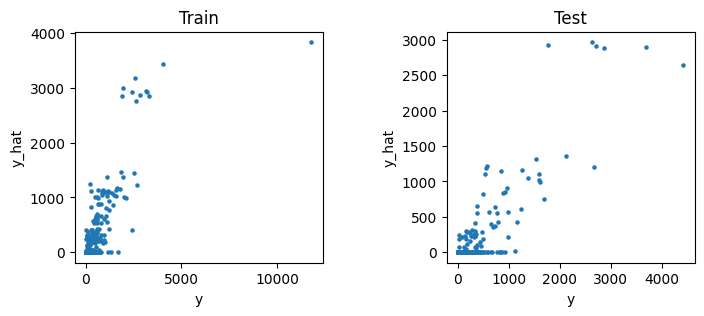

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plt.subplots_adjust(wspace=0.5)

y_hat_train = FNN_model(data.x, data.edge_index[:, data.train_idx], data.edge_attr[data.train_idx]).detach().numpy()
y_train = data.y[data.train_idx].numpy()

y_hat_test = FNN_model(data.x, data.edge_index[:, data.test_idx], data.edge_attr[data.test_idx]).detach().numpy()
y_test = data.y[data.test_idx].numpy()

ax1.scatter(y_train,y_hat_train, s=5)
ax1.set_xlabel("y")
ax1.set_ylabel("y_hat")
ax1.set_title("Train")

ax2.scatter(y_test,y_hat_test, s=5)
ax2.set_xlabel("y")
ax2.set_ylabel("y_hat")
ax2.set_title("Test")

plt.show()

In [114]:
print("R2 score for negative edges:", r2_score(y_test[y_test == 0], y_hat_test[y_test == 0].round()))
print("R2 score for positive edges:", r2_score(y_test[y_test > 0], y_hat_test[y_test > 0].round()).round(3))

R2 score for negative edges: 1.0
R2 score for positive edges: 0.72
